In [1]:
#This code is from openai baseline
#https://github.com/openai/baselines/tree/master/baselines/common/vec_env

import numpy as np
from multiprocessing import Process, Pipe

def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x()
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class VecEnv(object):
    """
    An abstract asynchronous, vectorized environment.
    """
    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a tuple of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a tuple of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

    
class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)
    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)

        
class SubprocVecEnv(VecEnv):
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True
            
    def __len__(self):
        return self.nenvs

In [2]:
#the basis for this code is https://github.com/higgsfield/RL-Adventure-2/blob/master/1.actor-critic.ipynb
#With a lost function
import math
import random

import gym
import numpy as np
from torch import autograd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gym_snake

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [12]:
num_envs = 16
env_name = "snake-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        env.alpha = .999
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)


env = gym.make(env_name)

In [6]:

def plot(frame_idx, rewards,std):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards,'b')
    plt.plot(np.array(rewards)+1.96/3.0*np.array(std),'b--')
    plt.plot(np.array(rewards)-1.96/3.0*np.array(std),'b--')
    plt.show()
    
def test_env(vis=False,breaks=True):
    state = env.reset()
    if vis:
        clear_output(True)
        env.render()
    done = False
    total_reward = 0
    i = 0
    while not done:
        i+=1
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if reward>0:
            i = 0
        if vis:
            clear_output(True)
            env.render()
            print(state)
        total_reward += reward
        if i > 1e4 and breaks:
            break
    return total_reward

In [7]:

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        

        self.actor =    self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value

In [8]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [9]:
num_inputs  = 9

num_outputs = envs.action_space.n

#Hyper params:
hidden_size = 256
num_steps   = 5

model  = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)

In [14]:
lr          = 1e-4
optimizer = optim.Adam(model.parameters(),lr)
max_frames   = 20000
frame_idx    = 0
test_rewards = []
test_std     = []

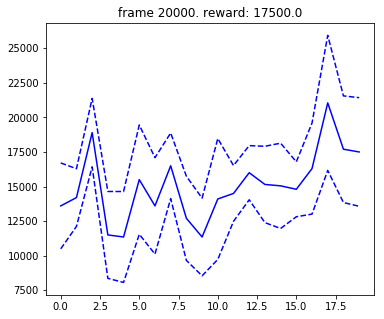

In [15]:
state = envs.reset()
alpha = 1
#best  = -100
#best_params = model.state_dict()
model.load_state_dict(best_params)
while frame_idx < max_frames:

    log_probs = []
    actions   = []
    values    = []
    rewards   = []
    masks     = []
    states    = []
    entropy = 0

    for _ in range(num_steps):
        alpha -=1.0/max_frames
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)
        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        action  = torch.tensor(action,dtype=torch.float)
        states.append(state)
        log_probs.append(log_prob)
        actions.append(action)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        state = next_state
        frame_idx += 1
        if frame_idx % 1000 == 0:
            r = [test_env() for _ in range(10)]
            test_rewards.append(np.mean(r))
            test_std.append(np.std(r))
            plot(frame_idx, test_rewards,test_std)
            #check if the results from this itteration of a statistically signficant mean 
            #better than previous itterations
            #if yes then model is new best model
            if np.sqrt(10)*(np.mean(r)-best)/np.std(r)>1.96:
                print(True)
                best = np.mean(r)
                best_params= model.state_dict()

            
    next_state = torch.FloatTensor(next_state).to(device)
    states    = torch.stack(states).detach()
    log_probs = torch.cat(log_probs).detach()
    actions  = torch.cat(actions).detach()
    values    = torch.cat(values).detach()
    epsilon = .2



    #for param in model.parameters():
        #print(param.grad)
    #print(actor_loss,critic_loss,entropy)
    for _ in range(5):
        _, next_value = model(next_state)
        new_dist, new_values = model(states.view(-1,9))
        returns     = compute_returns(next_value, rewards, masks,.95)
        returns     = torch.cat(returns).detach()
        #print(returns,returns.shape,new_values.shape)
        advantage   = returns - new_values
        new_probs   = new_dist.log_prob(actions)
        ratio       = torch.exp(new_probs-log_probs.detach())
        actor_loss  = -torch.max(ratio*advantage.detach(),
                                 torch.clamp(ratio,1-epsilon*alpha,1+epsilon*alpha)*advantage.detach()).mean()
        loss1       = advantage
        loss2       = returns-(values.detach()+torch.clamp(new_values-values.detach(),-epsilon*alpha,epsilon*alpha))
        critic_loss = torch.max(loss1,loss2).pow(2).mean()
        entropy     = new_dist.entropy().mean()
        loss        = (actor_loss+critic_loss-.01*entropy)*alpha
        with autograd.detect_anomaly():
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()



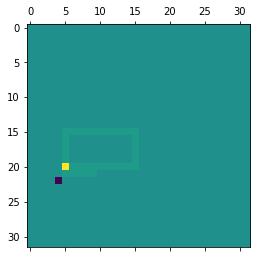

[0 1 1 1 0 1 0 1 0]


16900

In [23]:
model.load_state_dict(best_params)
test_env(True,False)


In [16]:
model.load_state_dict(best_params)
torch.save(model.state_dict(),'snake_model.pt')

In [10]:
model.load_state_dict(torch.load('snake_model.pt'))

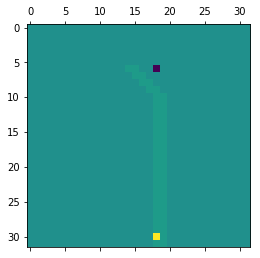

25400


In [17]:
vis = True
breaks = False
state = env.reset()
i = 0
if vis:
    clear_output(True)
    plt.matshow(10+env.world)
    plt.savefig('\images\snake{}.png'.format(i))
    plt.show()
done = False
total_reward = 0
while not done:
    i+=1
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    dist, _ = model(state)
    next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
    state = next_state
    #if reward>0:
        #i = 0
    if vis:
        clear_output(True)
        plt.matshow(10+env.world)
        plt.savefig('\images\snake{}.png'.format(i))
        plt.show()
    total_reward += reward
    #if i > 1e4 and breaks:
        #break
print(total_reward)